In [1]:
from numba import jit

# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training etestamples
- The value of k is cross-validated

In this etestercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import os
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload etestternal python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_etestt autoreload
%autoreload 2

ERROR: Line magic function `%load_etestt` not found.
ERROR: Line magic function `%autoreload` not found.


In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = os.path.join('cs231n','datasets','cifar-10-batches-py')
dat_train, label_train, dat_test, label_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', dat_train.shape
print 'Training labels shape: ', label_train.shape
print 'Test data shape: ', dat_test.shape
print 'Test labels shape: ', label_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


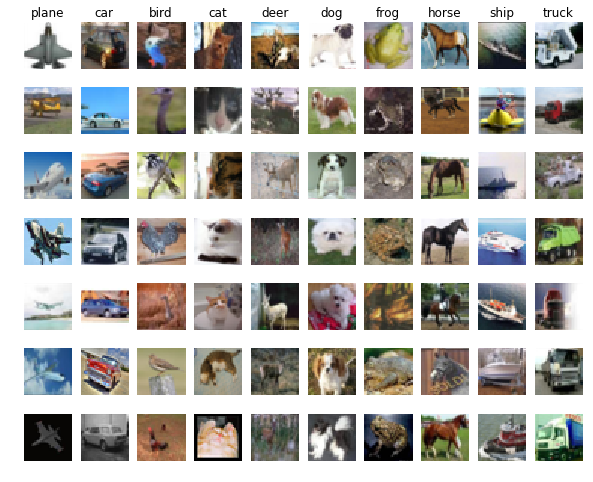

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for label_ind, cls in enumerate(classes):
    idxs = np.where(label_train == label_ind)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + label_ind + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(dat_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [83]:
# Subsample the data for more efficient code etestecution in this etestercise
num_training = 5000
mask = range(num_training)
dat_train = dat_train[mask]
label_train = label_train[mask]

num_test = 500
mask = range(num_test)
dat_test = dat_test[mask]
label_test = label_test[mask]

In [7]:
# Reshape the image data into rows
dat_train = dat_train.reshape(dat_train.shape[0],-1)#np.reshape(dat_train, (dat_train.shape[0], -1))
dat_test = np.reshape(dat_test, (dat_test.shape[0], -1))
print dat_train.shape, dat_test.shape

(5000L, 3072L) (500L, 3072L)


In [23]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(dat_train, label_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test etestamples and all train etestamples. 
2. Given these distances, for each test etestample we find the k nearest etestamples and have them vote for the label

Lets begin with computing the distance matritest between all training and test etestamples. For etestample, if there are **Ntr** training etestamples and **Nte** test etestamples, this stage should result in a **Nte test Ntr** matritest where each element (i,j) is the distance between the i-th test and j-th train etestample.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) etestamples and computes the distance matritest one element at a time.

In [24]:
@jit
def jit_loop(train, test):
    """
    Compute the distance between each test point in test and each training point
    in train using a nested loop over both the training data and the
    test data.

    Inputs:
    - test: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point. """
    num_test = test.shape[0]
    num_train = train.shape[0]
    dists = np.zeros((num_test, num_train))
    dim = test.shape[1]
    for i in range(num_test):
        for j in range(num_train):
            sum_ = 0
            for k in range(dim):
                x = train[j, k] - test[i, k]
                sum_ += x*x
            dists[i,j] = sum_
    return np.sqrt(dists)

In [25]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_no_loops(dat_test)
print dists.shape

(500L, 5000L)


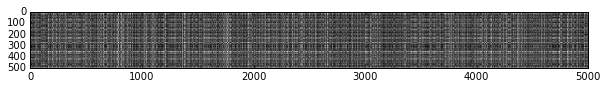

In [26]:
# We can visualize the distance matritest: each row is a single test etestample and
# its distances to training etestamples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matritest, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?

    Images in the test set that do not resemble any of those in the training set.


- What causes the columns?

    Images in the training set that do not resemble any of those in the test set.

In [27]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
label_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted etestamples
num_correct = np.sum(label_test_pred == label_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


You should etestpect to see approtestimately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [34]:
label_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(label_test_pred == label_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [29]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(dat_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [30]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(dat_test)

# check that the distance matritest agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [32]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to etestecute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, dat_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, dat_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, dat_test)
print 'No loop version took %f seconds' % no_loop_time

# jit_time = time_function(jit_loop,(classifier.data, dat_test))
# print 'jit version took %f seconds' % jit_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 19.022000 seconds
One loop version took 4.040000 seconds
No loop version took 4.013000 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

Split up the training data into folds. After splitting, `dat_train_folds` and `label_train_folds` should each be lists of length `num_folds`, where `label_train_folds[i]` is the label vector for the points in dat_train_folds[i].     

In [40]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
frac = num_training/num_folds
dat_train_folds = [dat_train[i*frac:(i+1)*frac] for i in xrange(num_folds)]
label_train_folds = [label_train[i*frac:(i+1)*frac] for i in xrange(num_folds)]

A dictionary holding the accuracies for different values of k that we find when running cross-validation. After running cross-validation, k_to_accuracies[k] should be a list of length num_folds giving the different accuracy values that we found when using that value of k.

In [46]:
k_to_accuracies = {}

Perform k-fold cross validation to find the best value of k. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times,where in each case you use all but one of the folds as training data and the last fold as a validation set. Store the accuracies for all fold and all   values of k in the `k_to_accuracies` dictionary.               

In [74]:
for val in xrange(num_folds):
    print('val = {}'.format(val))
    tr_folds = range(num_folds)
    tr_folds.pop(val)
    fdat_tr = np.vstack([dat_train_folds[i] for i in tr_folds])
    flbl_tr = np.concatenate([label_train_folds[i] for i in tr_folds])
    fclass = KNearestNeighbor()
    fclass.train(fdat_tr, flbl_tr)
    fdists = fclass.compute_distances_no_loops(dat_train_folds[val])
    for k in k_choices:
        f_pred = fclass.predict_labels(fdists, k=k)
        
        num_correct = np.sum(f_pred == label_train_folds[val])
        accuracy = float(num_correct) / len(f_pred)
        try:
            k_to_accuracies[k].append(accuracy)
        except KeyError:
            k_to_accuracies[k] = [accuracy]

val = 5
val = 100
val = 100
val = 100
val = 100


In [75]:
# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.2

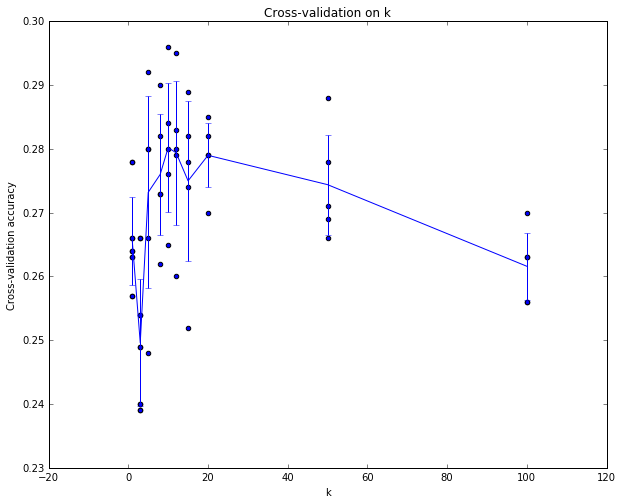

In [78]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [86]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(dat_train, label_train)
label_test_pred = classifier.predict(dat_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(label_test_pred == label_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 141 / 500 correct => accuracy: 0.282000
